# Cats & Dogs Image Classification 

#### Develop an image classification model to distinguish between images of cats and dogs using data science techniques in Python.

### Overview
- [Import libraries](#import-libraries)
- [Data analysis](#data-analysis)
- [Create image data generators](#create-image-data-generators)
- [Set up the model](#set-up-the-model)
   * [Load pretrained model](#load-pretrained-model)
   * [Create classification model](#create-classification-model)
- [Training](#training)
   * [Training the classification model](#training-the-classification-model)
   * [Fine-tuning](#fine-tuning)
- [Evaluate the final model](#evaluate-the-final-model)

<!-- TOC --><a name="import-libraries"></a>
# Import libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import warnings

warnings.filterwarnings('ignore')

C:\Users\Asus\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<!-- TOC --><a name="data-analysis"></a>
# Data analysis

In [ ]:
# Define data paths

test_dir = r"C:\Users\Asus\Desktop\Bharat Intern\Cats and Dogs IC Dataset\train"
train_dir = r"C:\Users\Asus\Desktop\Bharat Intern\Cats and Dogs IC Dataset\test"

In [ ]:
# Check size of each dataset

import os

def get_dataset_size(dir, type):
    print(f"Scanning {type} images...")
    size = 0
    for label in os.listdir(dir):
        size += len(os.listdir(os.path.join(dir, label)))
    print(f"Number of {type} images: {size}\n")
    return size

num_test = get_dataset_size(test_dir, "test")
num_train = get_dataset_size(train_dir, "train")

Scanning test images...
Number of test images: 557

Scanning train images...
Number of train images: 140



In [ ]:
num_classes = len(os.listdir(train_dir))
print(f"Number of classes: {num_classes}")

Number of classes: 2


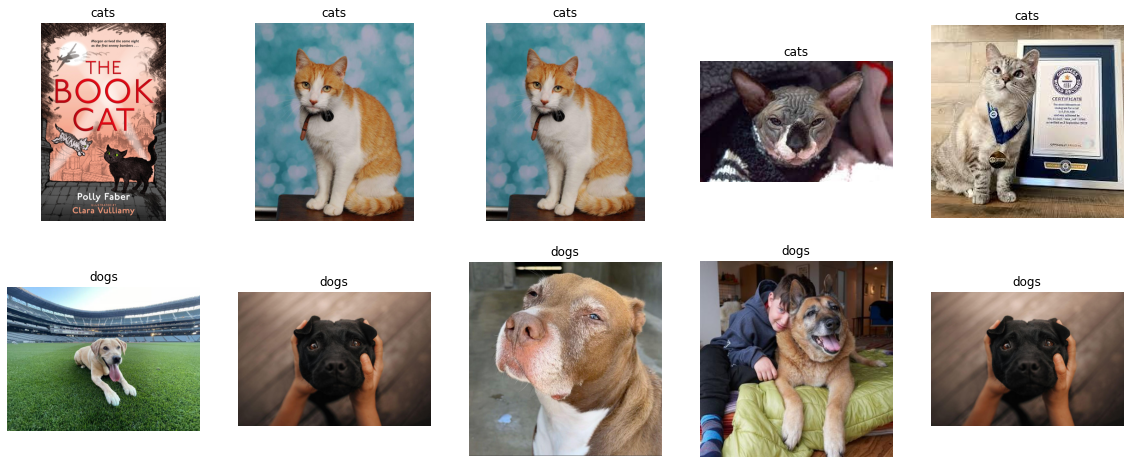

In [ ]:
# Let's view a few training samples

import random
import cv2

# imgs to plot per class
m = 5

fig, axs = plt.subplots(nrows=num_classes, ncols=m, figsize=(m*4, num_classes*4))

for i in range(num_classes):

    label = os.listdir(train_dir)[i]
    
    for j in range(m):
        
        # get a random image from the chosen species
        
        img_name = random.choice(os.listdir(os.path.join(train_dir, label)))
        img_path = os.path.join(train_dir, label, img_name)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # plot the image
        axs[i][j].imshow(image)
        axs[i][j].set_title(label)
        axs[i][j].axis("off")
        
fig.show()

<!-- TOC --><a name="create-image-data-generators"></a>
# Create image data generators

In [ ]:
# Let's create our image preprocessors

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    horizontal_flip=True,
)

test_datagen = ImageDataGenerator(
    validation_split=0.1
)

In [ ]:
# Let's define the target size

input_size = (224, 224)

In [ ]:
# Let's create our image generators

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=input_size,
    batch_size=32,
    shuffle=True,
)

val_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=input_size,
    batch_size=32,
    shuffle=True,
    subset="training"
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=input_size,
    batch_size=32,
    shuffle=False,
    subset="validation"
)

Found 140 images belonging to 2 classes.
Found 503 images belonging to 2 classes.
Found 54 images belonging to 2 classes.


<!-- TOC --><a name="set-up-the-model"></a>
# Set up the model

<!-- TOC --><a name="load-pretrained-model"></a>
## Load pretrained model

Let's load a Resnet50 model which has been pretrained on the ImageNet dataset

In [ ]:
#from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input

base_model = VGG19(
    include_top = False,
    weights="imagenet",
)



80134624/80134624 [==============================] - 34s 0us/step


In [ ]:
# Let's print out a description of the model layers

base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [ ]:
len(base_model.trainable_variables)

32

<!-- TOC --><a name="create-classification-model"></a>
## Create classification model

Let's add a classification head to this pretrained model

In [ ]:
# Before we add the classification head,
# Let's get the output shape of the ResNet (without the classification head)

image_batch, label_batch = next(iter(train_generator))
feature_batch = base_model(image_batch)
print(f"Output shape of feature extractor: {feature_batch.shape}")

Output shape of feature extractor: (32, 7, 7, 512)


In [ ]:
# Let's freeze the feature extractor

base_model.trainable = False

In [ ]:
# Add a global pooling layer to flatten the output of the feature extractor

from tensorflow.keras.layers import GlobalAveragePooling2D

global_average_layer = GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 512)


In [ ]:
# Add a fully connected layer

from tensorflow.keras.layers import Dense

prediction_layer = Dense(num_classes)
prediction_layer_output = prediction_layer(feature_batch_average)
print(prediction_layer_output.shape)

(32, 2)


In [ ]:
# Now let's combine all the layers into a complete model

inputs = tf.keras.Input(shape=input_size + (3,))
x = preprocess_input(inputs)
x = base_model(x)
x = global_average_layer(x)
outputs = prediction_layer(x)

model = tf.keras.Model(inputs, outputs)

In [ ]:
# Let's explore the model's layers

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (  (None, 224, 224, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 224, 224, 3)       0         
 )                                                               
                                                                 
 vgg19 (Functional)          (None, None, None, 512)   20024384  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                             

In [ ]:
len(model.trainable_variables)

2

<!-- TOC --><a name="training"></a>
# Training

<!-- TOC --><a name="training-the-classification-model"></a>
## Training the classification model

In [ ]:
# Let's compile the model


base_learning_rate = 0.0001

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
initial_epochs = 50

In [ ]:
loss0, accuracy0 = model.evaluate(val_generator)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))



16/16 [==============================] - 106s 7s/step - loss: 3.2142 - accuracy: 0.6163
initial loss: 3.21
initial accuracy: 0.62


In [ ]:
# Let's fit the model
# Remember, we are only training the classification head

history = model.fit(
    train_generator,
    epochs=initial_epochs,
    validation_data=val_generator
)

Epoch 1/50
5/5 [==============================] - 137s 32s/step - loss: 3.3321 - accuracy: 0.5929 - val_loss: 3.1582 - val_accuracy: 0.6183
Epoch 2/50
5/5 [==============================] - 127s 30s/step - loss: 3.1594 - accuracy: 0.6143 - val_loss: 3.1049 - val_accuracy: 0.6262
Epoch 3/50
5/5 [==============================] - 123s 29s/step - loss: 3.0112 - accuracy: 0.6143 - val_loss: 3.1285 - val_accuracy: 0.6282
Epoch 4/50
5/5 [==============================] - 125s 29s/step - loss: 2.7913 - accuracy: 0.6214 - val_loss: 3.0933 - val_accuracy: 0.6302
Epoch 5/50
5/5 [==============================] - 123s 29s/step - loss: 3.1318 - accuracy: 0.6143 - val_loss: 3.1029 - val_accuracy: 0.6342
Epoch 6/50
5/5 [==============================] - 126s 31s/step - loss: 2.6705 - accuracy: 0.6000 - val_loss: 2.9951 - val_accuracy: 0.6362
Epoch 7/50
5/5 [==============================] - 131s 32s/step - loss: 3.0368 - accuracy: 0.6000 - val_loss: 2.8184 - val_accuracy: 0.6461
Epoch 8/50
5/5 [====

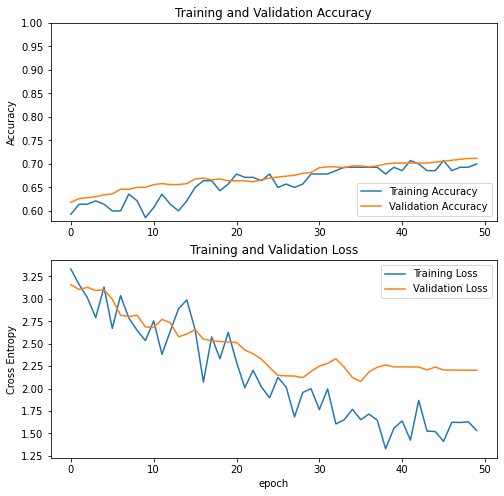

In [ ]:
# Let's plot the results of the training

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

<!-- TOC --><a name="fine-tuning"></a>
## Fine-tuning

Now that we've trained the classification head, let's train some of the top layers to greatly improve the performance of the model.

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 18

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

Number of layers in the base model:  22


In [ ]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
    metrics=['accuracy']
)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (  (None, 224, 224, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 224, 224, 3)       0         
 )                                                               
                                                                 
 vgg19 (Functional)          (None, None, None, 512)   20024384  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                             

In [ ]:
len(model.trainable_variables)

8

In [ ]:
earlystopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", 
    patience=5, 
    restore_best_weights=True
)

In [ ]:
# Let's fine tune the model

fine_tune_epochs = 50
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(
    train_generator,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    validation_data=val_generator,
    callbacks=[earlystopping]
)

Epoch 50/100
5/5 [==============================] - 89s 21s/step - loss: 1.6513 - accuracy: 0.7500 - val_loss: 0.8330 - val_accuracy: 0.8250
Epoch 51/100
5/5 [==============================] - 89s 21s/step - loss: 0.6355 - accuracy: 0.8714 - val_loss: 0.6490 - val_accuracy: 0.8688
Epoch 52/100
5/5 [==============================] - 105s 25s/step - loss: 0.3255 - accuracy: 0.9000 - val_loss: 0.5663 - val_accuracy: 0.8787
Epoch 53/100
5/5 [==============================] - 104s 25s/step - loss: 0.1800 - accuracy: 0.9429 - val_loss: 0.5300 - val_accuracy: 0.8887
Epoch 54/100
5/5 [==============================] - 94s 22s/step - loss: 0.1005 - accuracy: 0.9786 - val_loss: 0.4990 - val_accuracy: 0.8926
Epoch 55/100
5/5 [==============================] - 96s 23s/step - loss: 0.0575 - accuracy: 0.9929 - val_loss: 0.4775 - val_accuracy: 0.9046
Epoch 56/100
5/5 [==============================] - 96s 23s/step - loss: 0.0390 - accuracy: 1.0000 - val_loss: 0.4624 - val_accuracy: 0.9066
Epoch 57/10

Wow! That really boosted performance!

In [ ]:
# Update the accuracy and loss

acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

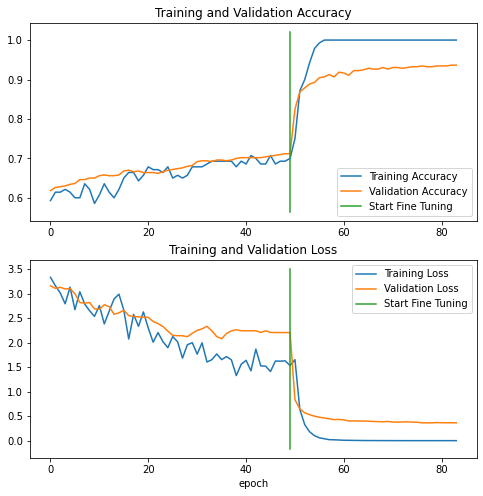

In [ ]:
# Plot the results!

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

<!-- TOC --><a name="evaluate-the-final-model"></a>
# Evaluate the final model

In [ ]:
loss, acc = model.evaluate(test_generator, verbose=False)
print(f"Validation accuracy: {acc*100}%")

Validation accuracy: 88.88888955116272%


##### The Accuracy of the model is almost 89% which indicate that the model is trained and fine-tuned for image classification.